# Libreria scikit-learn
Scikit-learn è una libreria di Python che può essere utilizzata per svolgere analisi di data mining sia supervisionate che non.
Implementa vari modelli e algoritmi di machine learning e si basa su NumPy, SciPy (una libreria di strumenti matematici) e matplotlib per la visualizzazione.

Può essere installata con *pip install scikit-learn* e importata con *import sklearn*.

La libreria è in grado di funzionare prendendo in ingresso dati direttamente da dataframe di Pandas, consentendone una completa integrazione.

Vediamo le operazioni che già abbiamo visto da un punto di vista teorico come possono essere applicate con scikit.
Nota: scikit non implementa algoritmi per trovare itemset frequenti e regole associative, vedremo come farlo con un’altra libreria.


## Selezione delle feature
Usiamo come esempi vari dataset di seaborn.
Carichiamo il dataset del Titanic e come fatto in precedenza sistemiamo i valori nulli e eliminiamo/convertiamo le feature non numeriche.


In [ ]:
import seaborn as sns
import pandas as pd

df = sns.load_dataset('titanic')

# Eliminamo valori nulli
df.drop('deck', axis=1, inplace=True)
df.dropna(subset=['embarked', 'embark_town'], inplace=True)
df.loc[df['age'].isna(), 'age'] = df['age'].median()

# Teniamo solo campi numerici
df.drop(['class', 'who', 'class', 'adult_male', 'embark_town', 'alive', 'alone'], axis=1, inplace=True)
df['family_size'] = df['sibsp'] + df['parch'] + 1
df.drop(['sibsp', 'parch'], axis=1, inplace=True)
df['sex'] = pd.factorize(df['sex'])[0]
df['embarked'] = pd.factorize(df['embarked'])[0]


La classe  `sklearn.feature_selection.VarianceThreshold(threshold=0.0)` consente di applicare il metodo della varianza per mantenere solo le feature che superano una certa soglia.
Di default elimina solo quelle a varianza zero, quindi che hanno tutti i valori identici.

La classe si può istanziare con:

In [ ]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=0.0)

La varianza può essere calcolata con il metodo fit(df), in generale in  scikit il metodo fit(dati) di un oggetto allena l’oggetto su quei dati.

In [ ]:
vt.fit(df)

VarianceThreshold()

Una volta applicato il metodo fit le varianze possono essere accedute con la proprietà vt.variances_ e l’informazione se una feature supera o meno la soglia prestabilita può essere ottenuta con il metodo vt.get_support() che ritorna un array ordinato di booleani per indicare se una colonna va mantenuta o meno.

Una versione nuova del dataframe con solo le feature di interesse può essere quindi calcolata con

In [ ]:
df.loc[:, vt.get_support()]

,survived,pclass,sex,age,fare,embarked,family_size
0,0,3,0,22.0,7.2500,0,2
1,1,1,1,38.0,71.2833,1,2
2,1,3,1,26.0,7.9250,0,1
3,1,1,1,35.0,53.1000,0,2
4,0,3,0,35.0,8.0500,0,1
...,...,...,...,...,...,...,...
886,0,2,0,27.0,13.0000,0,1
887,1,1,1,19.0,30.0000,0,1
888,0,3,1,28.0,23.4500,0,4
889,1,1,0,26.0,30.0000,1,1


E’ anche possibile ottenere solo i dati del dataframe come una matrice (senza le intestazioni) con il metodo vt.transform(df) che rimuoverà le colonne che non passano il filtro.

Nel caso del Titanic nessuna feature ha varianza 0 quindi vengono mantenute tutte.


Visto che il task nel dataset del Titanic è predire se un passeggero è sopravvissuto o meno, siamo in un caso supervisionato.
Il target è di tipo categorico: sopravvissuto o deceduto.
Le feature a disposizione sono, divise per tipo:
*	Categoriche: classe, sesso, molo d’imbarco.
*	Continue: età, prezzo del biglietto e dimensione della famiglia.

Possiamo quindi confrontare il target categorico con le variabili categoriche usando il test del Chi-Square, mentre le altre continue con il test di ANOVA.

Per compiere la selezione delle feature Scikit mette a disposizione la classe `sklearn.feature_selection.SelectKBest(score_func=, k=10)` dove:
*	score_func è la funzione che si vuole usare per assegnare un punteggio alle feature. Può essere importata sempre dal pacchetto sklearn.feature_selection tra le varie troviamo f_classif per calcolare ANOVA F-value nel caso di un task di classificazione, chi2 per calcolare il Chi-Quadro, f_regression per calcolare il test di ANOVA nel caso di una regressione.
*	k  indica quante feature si vogliono mantenere, se non specificato ne mantiene 10. Mantiene quelle con lo score più alto.

Una volta istanziata la classe ha quattro metodi principali:
*	fit(X, y): dove X un dataframe/matrice con i valori delle feature e y è una serie/array con i valori corrispondenti del target. Questo metodo inizializza l’oggetto sui dati.
*	transform(X): si aspetta sempre lo stesso X in ingresso e elimina le feature (colonne) che sono meno rilevanti. Non ritorna un dataframe, ma una matrice di valori.
*	get_support(X): ritorna un array di booleani per dire se una feature (colonna) deve essere mantenuta o meno.
*	get_feature_names_out(): ritorna i nomi delle features che vengono mantenute.

La classe presenta anche due proprietà utili:
*	scores_: contiene per ogni feature (nello stesso ordine in cui sono definite le colonne) il valore calcolato della metrica;
*	pvalue_: contiene per ogni feature (nello stesso ordine in cui sono definite le colonne) il valore calcolato del p-value.


Supponiamo quindi di voler mantenere solo due feature tra quelle categoriche, potremmo fare:

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

X = df[['pclass', 'sex', 'embarked']]
y = df['survived']

selector = SelectKBest(score_func=chi2, k=2)
selector.fit(X, y)
best_features_cat = selector.get_feature_names_out()
best_features_cat

array(['pclass', 'sex'], dtype=object)

La stessa operazione si può fare sulle feature continue, essendo questo un task di classificazione si può scegliere come metrica f_classif.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
X = df[['age', 'fare', 'family_size']]
y = df['survived']
selector = SelectKBest(score_func= f_classif, k=2)
selector.fit(X, y)
best_features_cont = selector.get_feature_names_out()
best_features_cont

array(['age', 'fare'], dtype=object)

Possiamo quindi mantenere solo le feature che ci interessano facendo:

In [ ]:
df.loc[:, (['survived']+list(best_features_cat)+list(best_features_cont))]

,survived,pclass,sex,age,fare
0,0,3,0,22.0,7.2500
1,1,1,1,38.0,71.2833
2,1,3,1,26.0,7.9250
3,1,1,1,35.0,53.1000
4,0,3,0,35.0,8.0500
...,...,...,...,...,...
886,0,2,0,27.0,13.0000
887,1,1,1,19.0,30.0000
888,0,3,1,28.0,23.4500
889,1,1,0,26.0,30.0000


## Clustering con il k-means

Vediamo ora come poter applicare il k-means per eseguire il clustering.

Il K-Means in scikit è implementato nella classe `sklearn.cluster.KMeans(n_cluster=, random_state=None)` dove n_cluster è il numero di cluster che si vuole ottenere, mentre random_state è un valore intero che rende deterministica la scelta dei centroidi iniziali, se non è impostato ad ogni esecuzione saranno scelti centroidi randomici.
Una volta istanziato l’oggetto mette a disposizione i seguenti metodi:
*	fit(X): dove X un dataframe/matrice con i valori numerici. Questo metodo applica il k-means sui dati.
*	predict(X): si aspetta sempre lo stesso X in ingresso e restituisce per ogni record l’id del cluster a cui è stato assegnato partendo da 0. Quindi se si impone n_cluster=3 si avranno gli id dei cluster 0, 1, 2.
Inoltre, sono a  disposizione le seguenti proprietà:
*	cluster_centers_: ritorna le coordinate dei centroidi di ogni cluster in un array.
*	inertia_: ritorna il WCSS, ossia la somma del quadrato della distanza euclidea di ogni punto al suo centroide.


Prendiamo ad esempio il dataset mpg di seaborn che contiene varie informazioni su diversi modelli di auto.

Lo carichiamo ed eliminiamo eventuali valori nulli (ci sono un paio di righe) e teniamo solo i valori numerici


In [ ]:
df = sns.load_dataset('mpg')
df.dropna(inplace=True)
df1 = df[['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']].copy()

In [ ]:
# Ora possiamo importare la classe k-means
from sklearn.cluster import KMeans

Adesso potremmo sfruttare l’elbow method per cercare di determinare il miglior numero dei cluster, eseguiamo quindi il k-means con diversi k, manteniamo il WCSS di ogni esecuzione e lo visualizziamo in un grafico


<Axes: >

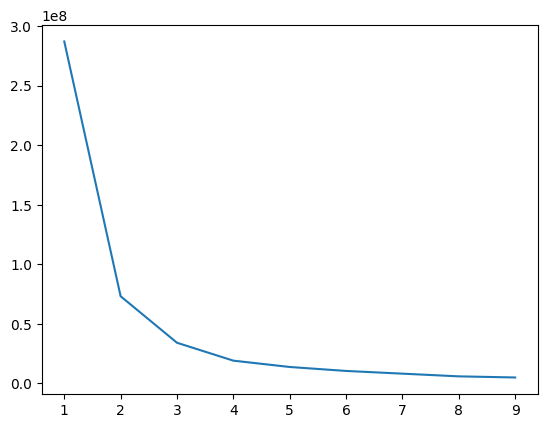

In [ ]:
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df1)
    wcss.append(kmeans.inertia_)

sns.lineplot(x=range(1, 10), y=wcss)

In questo grafico possiamo vedere  che WCSS cala in modo netto tra 1 e 2, poi tra 2 e 3 mentre tra 3 e 4 il calo inizia a ridursi.
Possiamo scegliere quindi K=3.

Ora possiamo applicare il K-Means con K=3 sui dati e assegnare ad ogni record il cluster id corrispondente


In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df1)
df['cluster'] = kmeans.predict(df1)

Possiamo effettuare una visualizzazione dei vari elementi colorati per i cluster individuati cercando di dare un'interpretazione ai vari cluster.

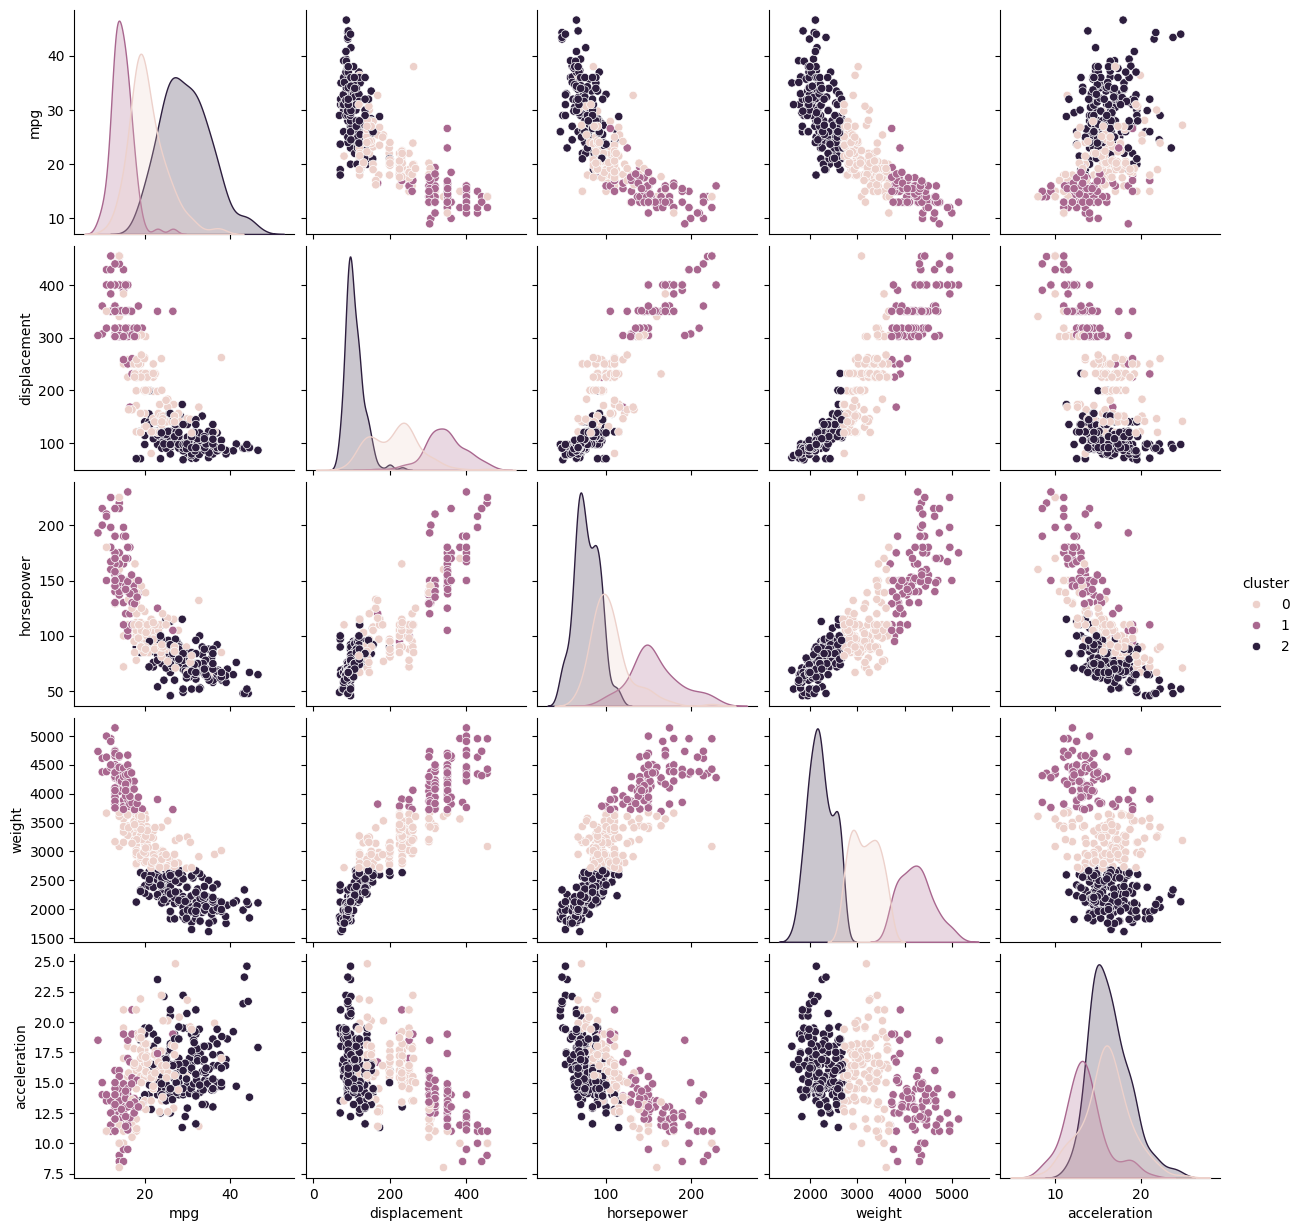

In [ ]:
sns.pairplot(data=df, hue='cluster', x_vars=['mpg', 'displacement', 'horsepower', 'weight', 'acceleration'], y_vars=['mpg', 'displacement', 'horsepower', 'weight', 'acceleration'])

## PCA
La PCA può essere trovata all’interno della classe sklearn.decomposition.PCA prende in ingresso il parametro n_components che indica quanti componenti si vogliono ottenere.

Implementa i seguenti metodi:
*	fit(X): dove X un dataframe/matrice con i valori delle feature. Inizializza la PCA per lavorare su X.
*	transform(X): si aspetta sempre lo stesso X in ingresso, ritorna le componenti principali di X.
*	fit_transform(X): esegue in serie fit e transform ritornando le componenti principali di X.

Se l’applichiamo sui dati precedenti e eseguiamo una visualizzazione, si può vedere come le componenti principali individuate rispecchino la divisione nei tre gruppi individuati anche dal k-means.



<Axes: xlabel='pca1', ylabel='pca2'>

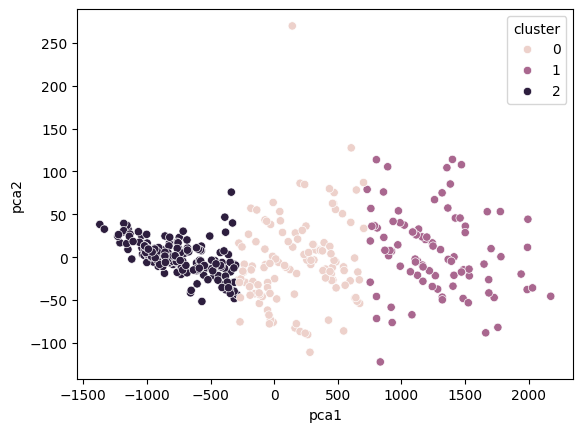

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
df[['pca1', 'pca2']] = pca.fit_transform(df1)
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster')